
## 🔋 **Advanced SOC Estimation using Rendom Forest Regression**

🧠 We use Rendom Forest Regression to estimate the State of Charge (SOC) of a lithium-ion battery using data inspired by NASA's battery dataset.

🧠 We use Random Forest over LSTM for State of Charge (SoC) estimation because it provides a quicker, interpretable solution with minimal data preprocessing. It works well with smaller datasets, is robust to noise, and can handle non-linear relationships between features like voltage, current, and temperature without the need for sequential input. Additionally, its fast training time and suitability for real-time applications make it ideal for prototyping and scenarios where computational resources are limited.

---

### 🔗 Dataset:
**NASA Battery Data Set**: From NASA Ames Prognostics Data Repository

We'll simulate similar data here for demonstration. You can easily replace this with real CSV files from NASA's repository.


## 🔑 **Step 0: Import Libraries**

In [21]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf



sns.set(style="whitegrid")


## 📁 **Step 1: Simulate Battery Data**

In [25]:
battery_data = pd.read_excel('/content/Nasa_Battery_001_50000.xlsx')
battery_data['Time_diff'] = battery_data['Time'].diff().fillna(0)
battery_data['Ah'] = (battery_data['Current_load'] * battery_data['Time_diff']) / 3600
battery_data['SOC'] = 100 - battery_data['Ah'].cumsum() / 2 * 100  # Assume 2 Ah battery

# Clip to keep SOC between 0 and 100
battery_data['SOC'] = battery_data['SOC'].clip(lower=0, upper=100)

# Drop NaNs or infinite values if any
battery_data = battery_data.dropna()

# Drop Columns
battery_data.drop(columns=['Current_load','Voltage_load','Time','Time_diff', 'Ah'], inplace=True)

df = pd.DataFrame({
   'Voltage': battery_data['Voltage_measured'],
   'Current': battery_data['Current_measured'],
   'Temperature': battery_data['Temperature_measured'],
   'SOC': battery_data['SOC']
})

##🧹 **Step 2: Preprocess and Sequence Data**

In [26]:
# Features and target
X = df[['Voltage', 'Current', 'Temperature']] # Removed 'Time' as it's not in df
y = df['SOC']

# Split into train and test sets
from sklearn.model_selection import train_test_split # import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 🤖 **Step 3: Define and Train Rendom Forest Model**


In [27]:
# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## 📊 **Step 4: Evaluate and Visualize Results**

Mean Absolute Error: 0.40
Root Mean Squared Error: 3.70
R² Score: 0.51


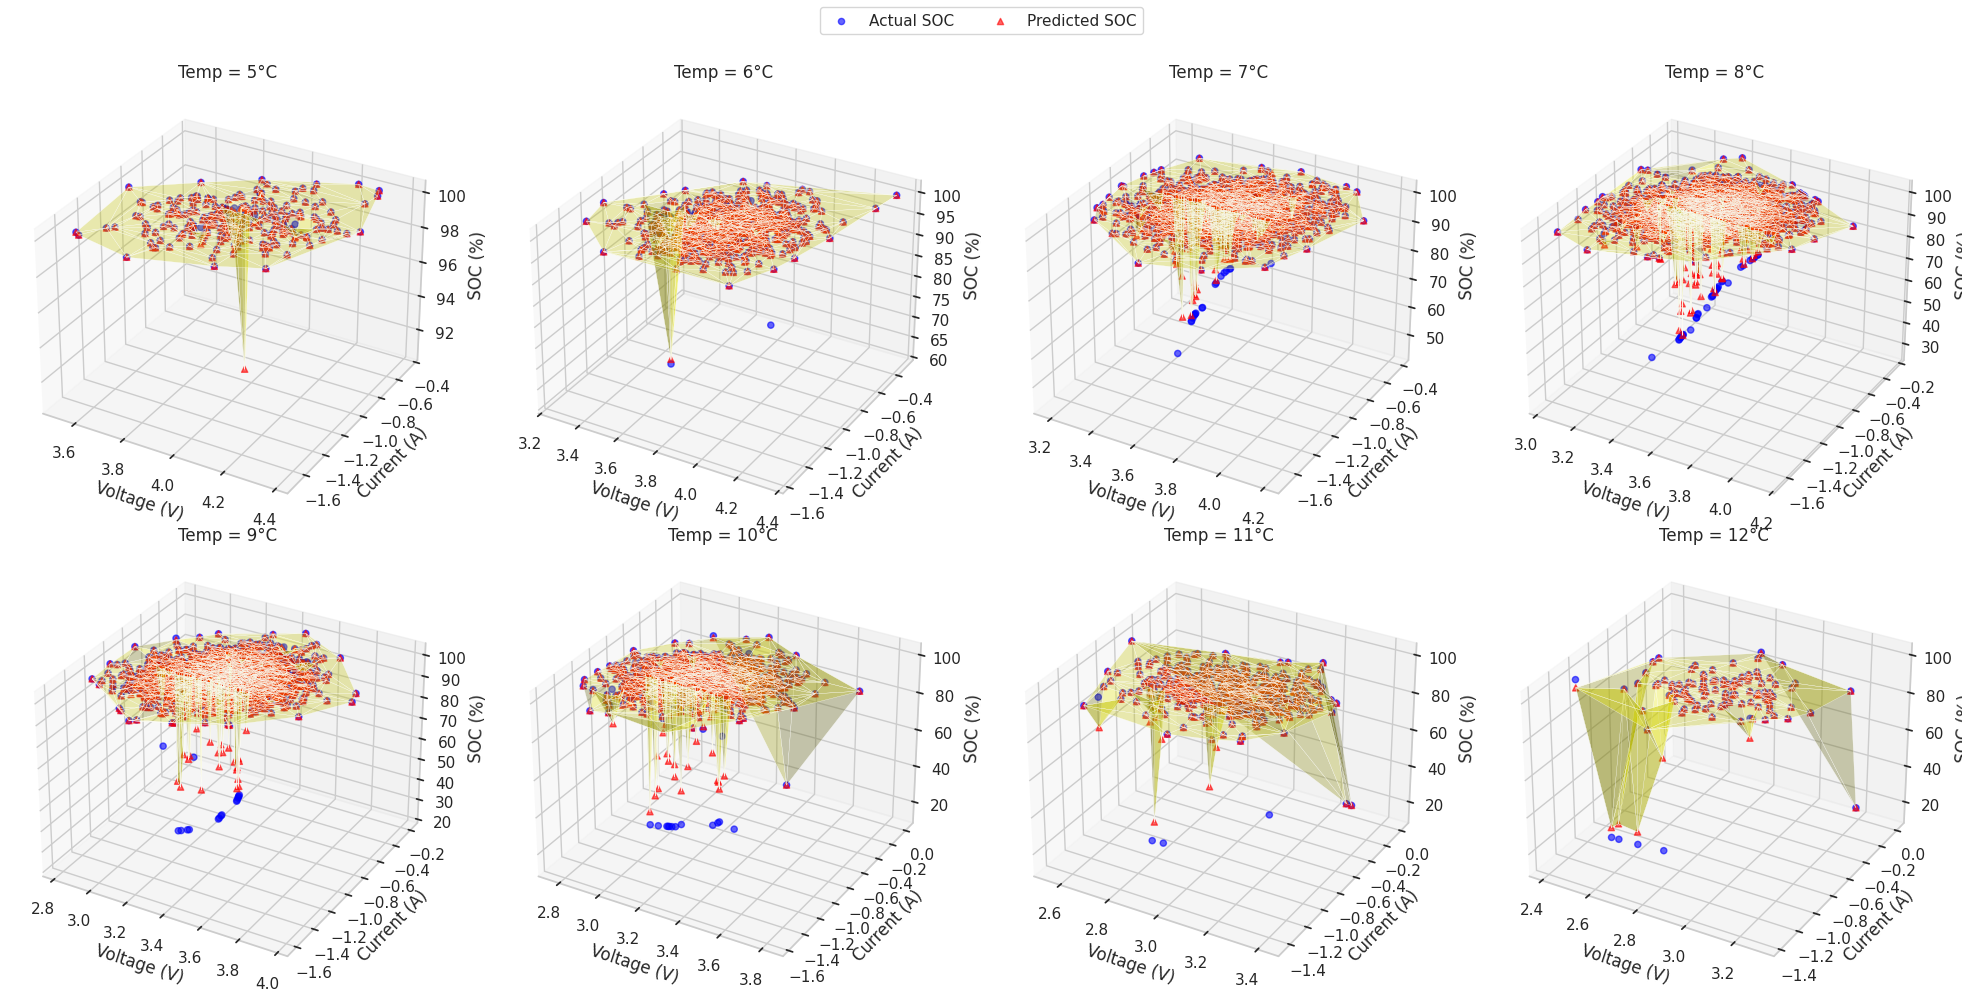

In [36]:
# Predict on test set
y_pred = model.predict(X_test)

# Calculate error metrics
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Round temperature to nearest integer for filtering
X_test_rounded = X_test.copy()
X_test_rounded['Temperature'] = X_test_rounded['Temperature'].round().astype(int)
y_test_array = y_test.to_numpy()
y_pred_array = y_pred

temps_to_plot = list(range(5, 13))
num_plots = len(temps_to_plot)
cols = 4
rows = (num_plots + cols - 1) // cols  # Ceiling division

fig = plt.figure(figsize=(20, 10))  # Adjust size as needed

plot_index = 1
for temp in temps_to_plot:
    mask = X_test_rounded['Temperature'] == temp
    if mask.sum() == 0:
        continue  # Skip if no data for this temperature

    xs = X_test.loc[mask, 'Voltage'].to_numpy()
    ys = X_test.loc[mask, 'Current'].to_numpy()
    zs_actual = y_test_array[mask]
    zs_pred = y_pred_array[mask]

    ax = fig.add_subplot(rows, cols, plot_index, projection='3d')

    ax.scatter(xs, ys, zs_actual, c='blue', label='Actual SOC', alpha=0.6)
    ax.scatter(xs, ys, zs_pred, c='red', label='Predicted SOC', alpha=0.6, marker='^')
    ax.plot_trisurf(xs, ys, zs_pred, color='yellow', alpha=0.3, linewidth=0.2)

    ax.set_title(f'Temp = {temp}°C')
    ax.set_xlabel('Voltage (V)')
    ax.set_ylabel('Current (A)')
    ax.set_zlabel('SOC (%)')

    plot_index += 1

# Create a shared legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for shared legend
plt.show()
